<a href="https://colab.research.google.com/github/anastasiia784/Data-Analyst-/blob/main/Portfolio_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 1

In this portfolio project, I built sales analytics for an online store using three tools: SQL, Python, and Tableau.

In [49]:
# Install required libraries for BigQuery and data analysis
import pandas as pd
import numpy as np

from google.colab import auth
from google.cloud import bigquery

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from itertools import combinations
from scipy.stats import shapiro, mannwhitneyu, kruskal, chi2_contingency, ttest_ind, ks_2samp


sns.set_palette("coolwarm")
# Authorization and connection to BigQuery
auth.authenticate_user()
client = bigquery.Client(project="data-analytics-mate")

## SQL Query

In [3]:
# Main SQL query to build the analytical dataset

query = """
SELECT
    s.date AS order_date,
    s.ga_session_id,

    -- Session parameters
    sp.continent,
    sp.country,
    sp.device,
    sp.browser,
    sp.mobile_model_name,
    sp.operating_system,
    sp.language,
    sp.medium,
    sp.channel,

    -- Account info (registered users)
    a.id AS account_id,
    a.is_verified,
    a.is_unsubscribed,

    -- Product info
    p.category,
    p.name AS product_name,
    p.price,
    p.short_description

FROM `data-analytics-mate.DA.session` AS s

-- Orders: not every session has an order
LEFT JOIN `data-analytics-mate.DA.order` AS o
    ON s.ga_session_id = o.ga_session_id

-- Product details
LEFT JOIN `data-analytics-mate.DA.product` AS p
    ON o.item_id = p.item_id

-- Session metadata
LEFT JOIN `data-analytics-mate.DA.session_params` AS sp
    ON s.ga_session_id = sp.ga_session_id

-- Account-session mapping (few registered users)
LEFT JOIN `data-analytics-mate.DA.account_session` AS acc_s
    ON s.ga_session_id = acc_s.ga_session_id

-- Account data
LEFT JOIN `data-analytics-mate.DA.account` AS a
    ON acc_s.account_id = a.id
"""


In [4]:
# Load data directly into a Pandas DataFrame
df = client.query(query).to_dataframe()


##Initial overview and description of the dataset

In [5]:
# Preview dataset
df.head()

# Dataset structure overview
df.info()

# Number of columns
df.shape[1]

# Numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns
num_cols

# Categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols

# Convert date column to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Number of unique sessions
df['ga_session_id'].nunique()

# Time period
df['order_date'].min(), df['order_date'].max()

# Missing values analysis
(df.isna().mean() * 100).sort_values(ascending=False)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

,0
is_unsubscribed,92.005321
is_verified,92.005321
account_id,92.005321
short_description,90.405241
product_name,90.405241
category,90.405241
price,90.405241
language,32.689925
ga_session_id,0.000000
order_date,0.000000


## Business Questions & Insights

### Sales by Continents and Countries

This analysis identifies the top-performing continents (Top-3) and countries (Top-5) based on total sales and number of orders.
The goal is to understand geographic concentration of revenue and demand.

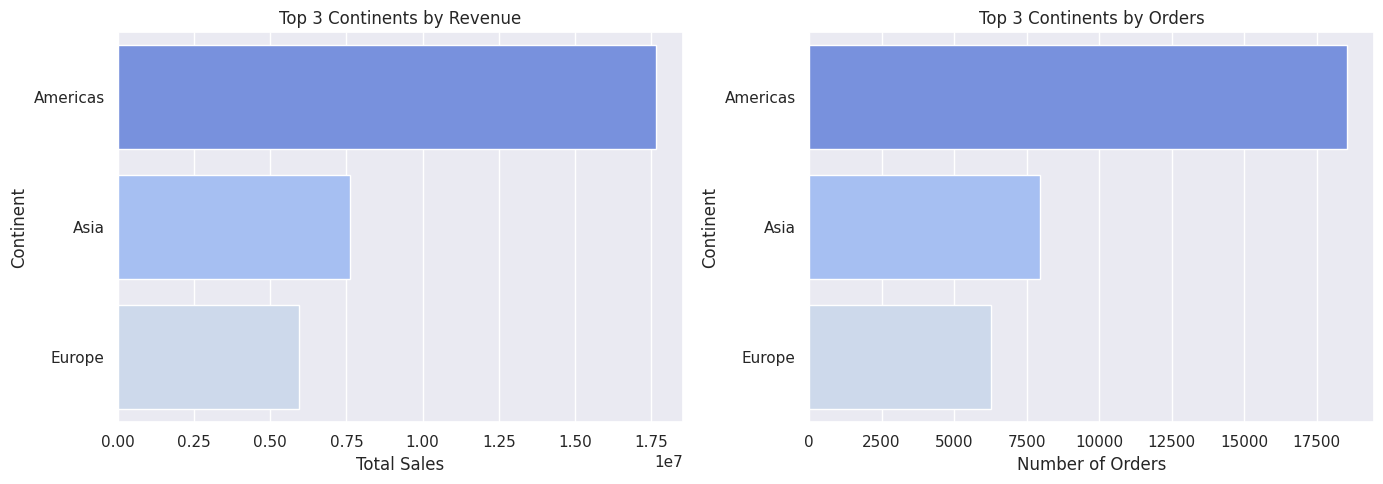

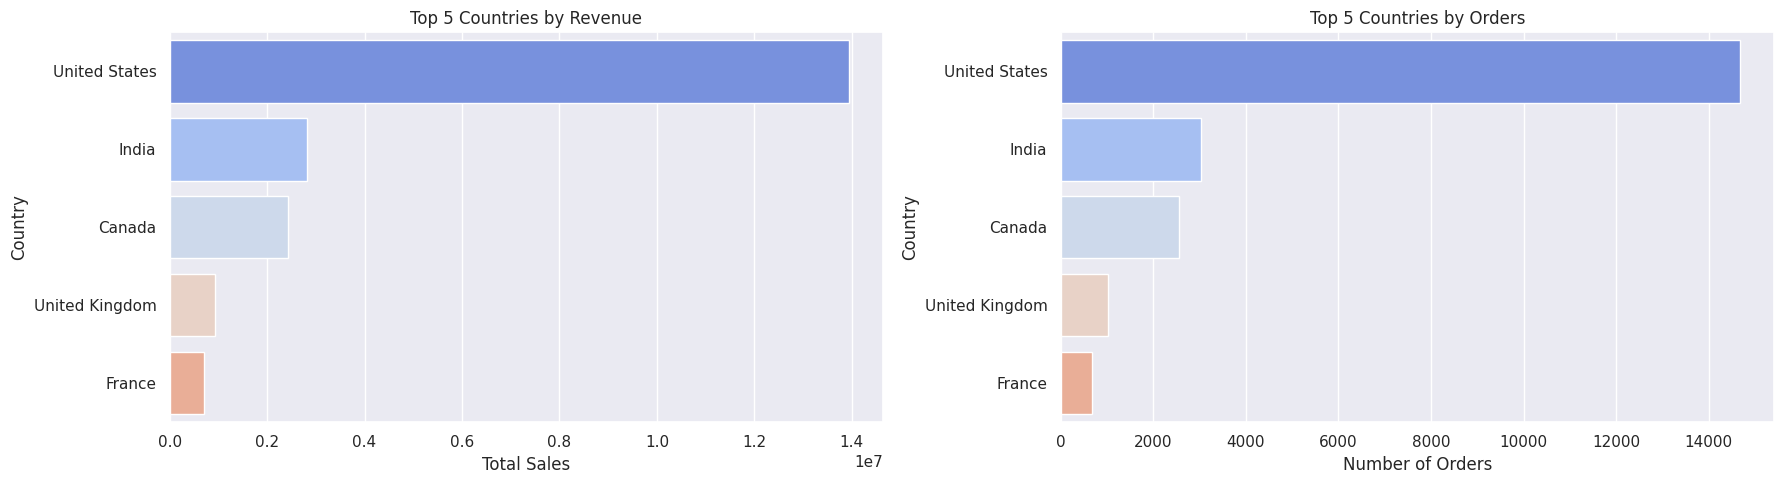

In [6]:
sales_df = df[df['price'].notna()].copy()


# Top 3 continents by revenue
top_continents_sales = (
    sales_df.groupby('continent', as_index=False)
    .agg(total_sales=('price','sum'))
    .sort_values('total_sales', ascending=False)
)
top_continents_sales.head(3)

# Top continents by number of orders
top_continents_orders = (
    sales_df.groupby('continent', as_index=False)
    .agg(orders=('ga_session_id','count'))
    .sort_values('orders', ascending=False)
)
top_continents_orders.head(3)

# Top 5 countries by revenue
top_countries_sales = (
    sales_df.groupby('country', as_index=False)
    .agg(total_sales=('price','sum'))
    .sort_values('total_sales', ascending=False)
)
top_countries_sales.head(5)

# Top countries by number of orders
top_countries_orders = (
    sales_df.groupby('country', as_index=False)
    .agg(orders=('ga_session_id','count'))
    .sort_values('orders', ascending=False)
)
top_countries_orders.head(5)

# Set global Seaborn style
sns.set(style="darkgrid")

# Choose a custom palette for all plots
custom_palette = "coolwarm"
sns.set_palette(custom_palette)


# Top 3 Continents by Revenue & Orders
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Top 3 Continents by Revenue
top3_cont_sales = top_continents_sales.head(3)
sns.barplot(x='total_sales', y='continent', data=top3_cont_sales, ax=axes[0],
            hue='continent', dodge=False, legend=False)
axes[0].set_title('Top 3 Continents by Revenue')
axes[0].set_xlabel('Total Sales')
axes[0].set_ylabel('Continent')

# Top 3 Continents by Orders
top3_cont_orders = top_continents_orders.head(3)
sns.barplot(x='orders', y='continent', data=top3_cont_orders, ax=axes[1],
            hue='continent', dodge=False, legend=False)
axes[1].set_title('Top 3 Continents by Orders')
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Continent')

plt.tight_layout()
plt.show()

# Top 5 Countries by Revenue & Orders
fig, axes = plt.subplots(1, 2, figsize=(18,5))

# Top 5 Countries by Revenue
top5_country_sales = top_countries_sales.head(5)
sns.barplot(x='total_sales', y='country', data=top5_country_sales, ax=axes[0],
            hue='country', dodge=False, legend=False)
axes[0].set_title('Top 5 Countries by Revenue')
axes[0].set_xlabel('Total Sales')
axes[0].set_ylabel('Country')

# Top 5 Countries by Orders
top5_country_orders = top_countries_orders.head(5)
sns.barplot(x='orders', y='country', data=top5_country_orders, ax=axes[1],
            hue='country', dodge=False, legend=False)
axes[1].set_title('Top 5 Countries by Orders')
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Country')

plt.tight_layout()
plt.show()



### Top-10 Product Categories by Revenue

This section ranks product categories by total revenue to identify key drivers of overall business performance.

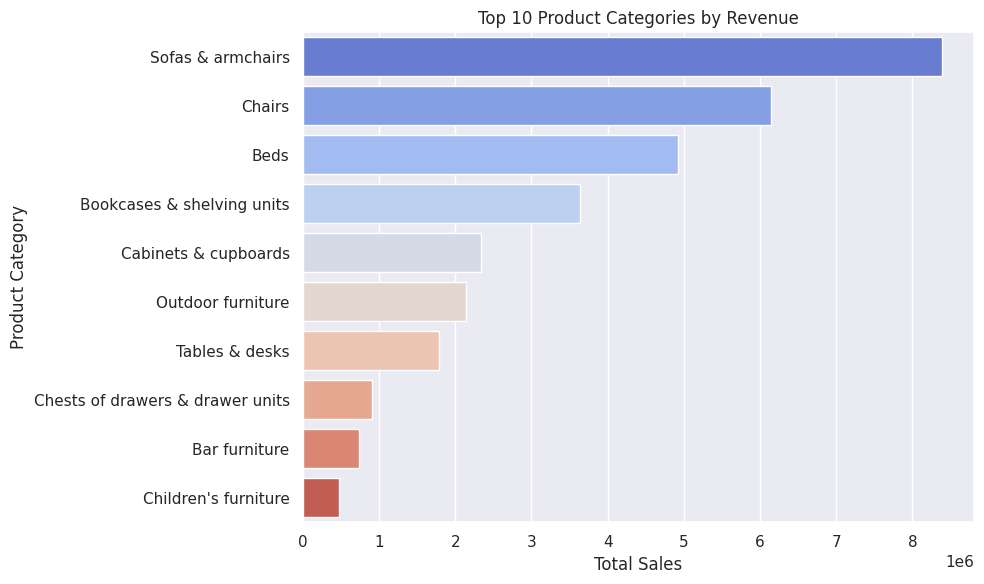

In [7]:
category_sales = (
    sales_df.groupby('category', as_index=False)
    .agg(total_sales=('price','sum'))
    .sort_values('total_sales', ascending=False)
    .head(10)
)

# Visualization of top 10 categories


plt.figure(figsize=(10,6))
sns.barplot(x='total_sales', y='category', data=category_sales,
            hue='category', dodge=False, palette='coolwarm', legend=False)
plt.title('Top 10 Product Categories by Revenue')
plt.xlabel('Total Sales')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


### Top-10 Product Categories in the Best-Performing Country

This analysis focuses on the country with the highest total sales and examines whether its category structure differs from the global distribution.

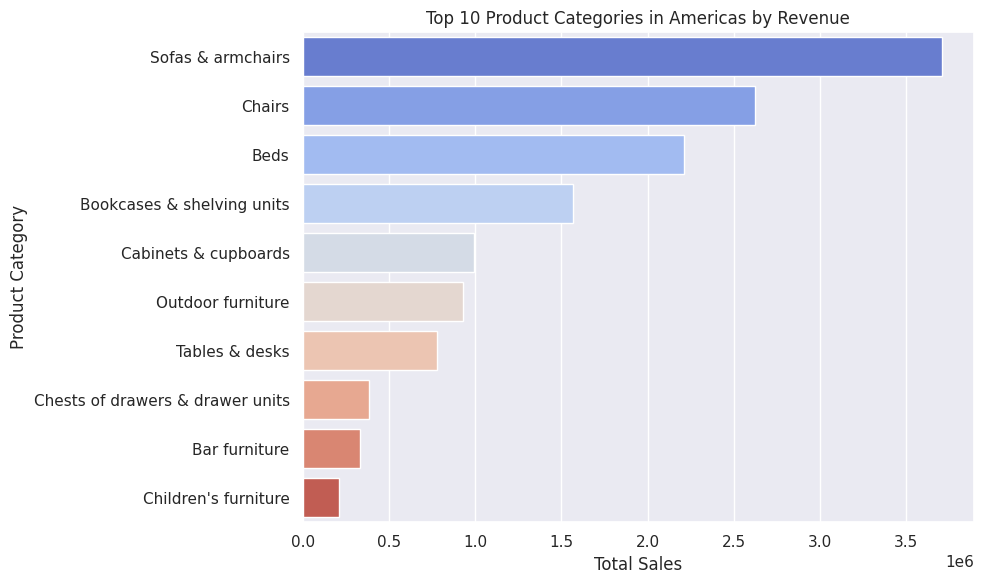

In [9]:
# Step 1: Find the country with the highest total sales
top_country = (
    sales_df.groupby('country', as_index=False)
    .agg(total_sales=('price','sum'))
    .sort_values('total_sales', ascending=False)
    .iloc[0]['country']
)

# Step 2: Filter sales for the top country
top_country_sales = sales_df[sales_df['country'] == top_country]

# Step 3: Group by category and sum total sales, then select top 10
top_country_category_sales = (
    top_country_sales.groupby('category', as_index=False)
    .agg(total_sales=('price','sum'))
    .sort_values('total_sales', ascending=False)
    .head(10)
)

# Display the top 10 categories table
top_country_category_sales
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.barplot(
    x='total_sales',
    y='category',
    data=top_country_category_sales,
    hue='category',       # Assign hue to category to avoid deprecation warning
    dodge=False,          # Disable bar dodge
    palette='coolwarm',   # Color palette
    legend=False          # Hide legend
)
plt.title('Top 10 Product Categories in Americas by Revenue')
plt.xlabel('Total Sales')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


### Sales by Device Type and Model (% of Total Revenue)

Sales are analyzed across device types and models to understand how user hardware impacts revenue contribution.

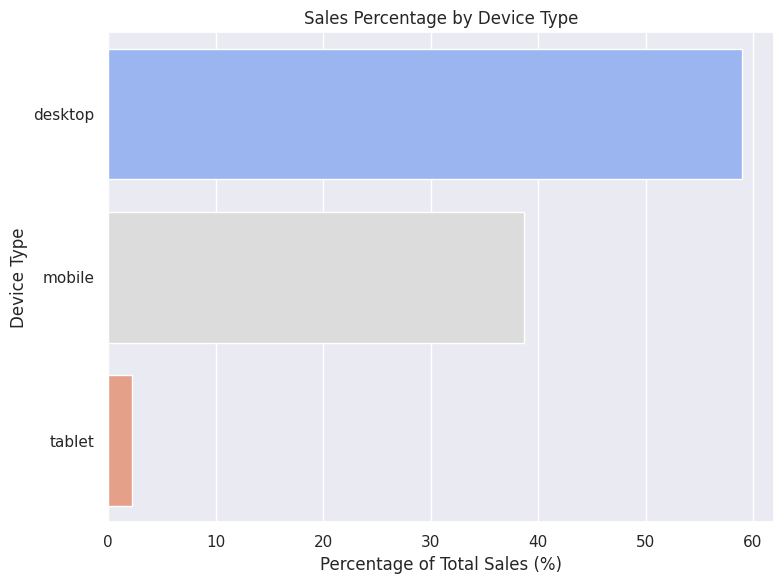

In [10]:
# Step 1: Filter only sessions with purchases
device_sales_df = sales_df[sales_df['price'].notna()]

# Step 2: Group by device type and sum sales
device_type_sales = (
    device_sales_df.groupby('device', as_index=False)
    .agg(total_sales=('price','sum'))
)

# Step 3: Calculate percentage of total sales per device type
device_type_sales['sales_pct'] = 100 * device_type_sales['total_sales'] / device_type_sales['total_sales'].sum()

# Display table
device_type_sales

# Visualization: Sales percentage by device type
plt.figure(figsize=(8,6))
sns.barplot(
    x='sales_pct',
    y='device',
    data=device_type_sales,
    hue='device',      # Assign hue to device to avoid deprecation warning
    dodge=False,
    palette='coolwarm',
    legend=False
)
plt.title('Sales Percentage by Device Type')
plt.xlabel('Percentage of Total Sales (%)')
plt.ylabel('Device Type')
plt.tight_layout()
plt.show()


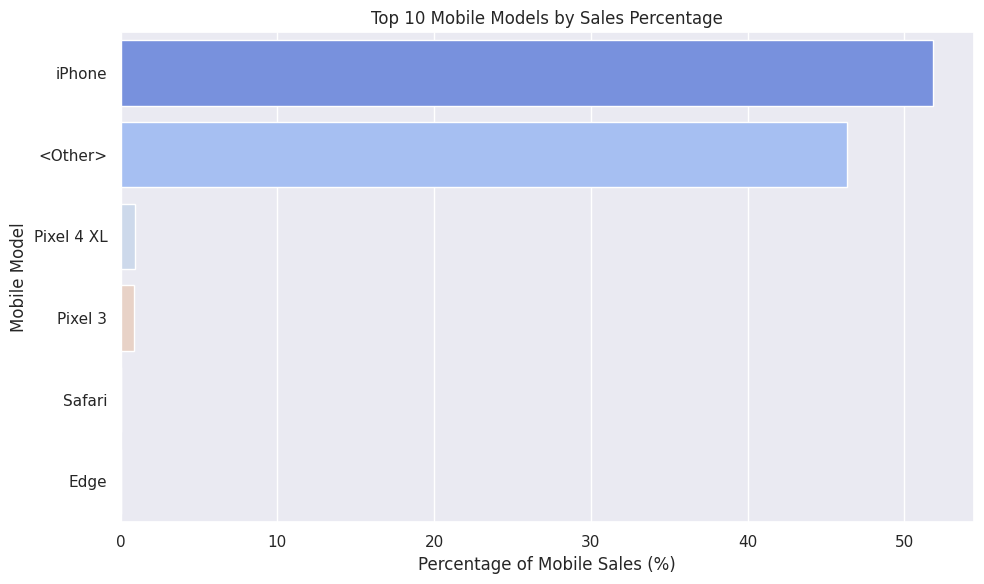

In [11]:
# Step 4: Group by mobile model (only for mobile devices) and sum sales
mobile_sales_df = device_sales_df[device_sales_df['device']=='mobile']

mobile_model_sales = (
    mobile_sales_df.groupby('mobile_model_name', as_index=False)
    .agg(total_sales=('price','sum'))
    .sort_values('total_sales', ascending=False)
    .head(10)  # Top 10 mobile models
)

# Calculate percentage of total sales (only mobile)
mobile_model_sales['sales_pct'] = 100 * mobile_model_sales['total_sales'] / mobile_model_sales['total_sales'].sum()

# Display table
mobile_model_sales

# Visualization: Top 10 Mobile Models by Sales Percentage
plt.figure(figsize=(10,6))
sns.barplot(
    x='sales_pct',
    y='mobile_model_name',
    data=mobile_model_sales,
    hue='mobile_model_name',
    dodge=False,
    palette='coolwarm',
    legend=False
)
plt.title('Top 10 Mobile Models by Sales Percentage')
plt.xlabel('Percentage of Mobile Sales (%)')
plt.ylabel('Mobile Model')
plt.tight_layout()
plt.show()


### Sales by Traffic Source (% of Total Revenue)

This section evaluates the contribution of different traffic sources to total sales, highlighting the most effective acquisition channels.

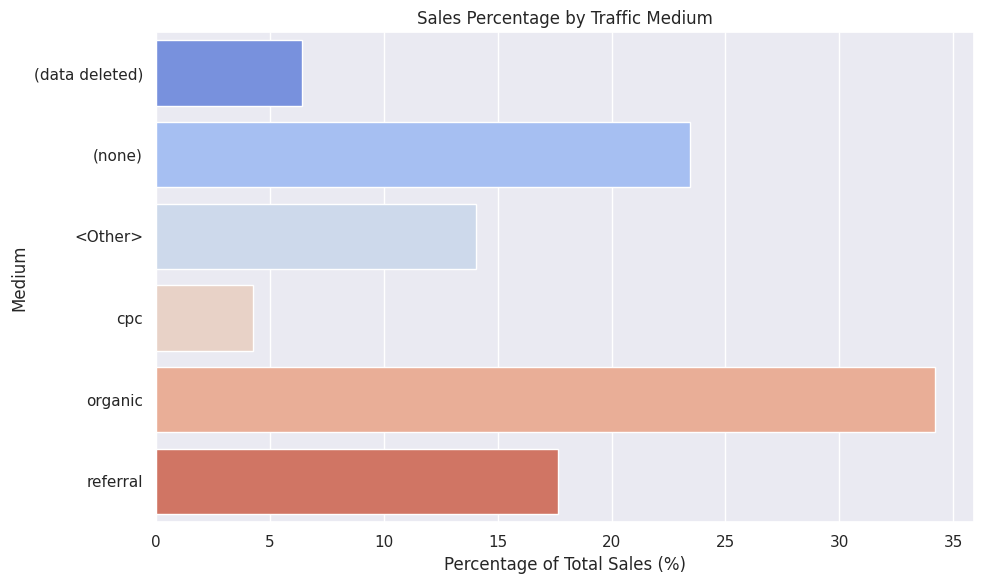

In [12]:
# Step 1: Filter only sessions with purchases
traffic_sales_df = sales_df[sales_df['price'].notna()]

# -----------------------------
# Analysis by Medium
# -----------------------------
medium_sales = (
    traffic_sales_df.groupby('medium', as_index=False)
    .agg(total_sales=('price','sum'))
)

# Calculate percentage of total sales per medium
medium_sales['sales_pct'] = 100 * medium_sales['total_sales'] / medium_sales['total_sales'].sum()

# Display table
medium_sales
# Visualization: Sales percentage by Medium
plt.figure(figsize=(10,6))
sns.barplot(
    x='sales_pct',
    y='medium',
    data=medium_sales,
    hue='medium',        # Assign hue to medium to avoid deprecation warning
    dodge=False,
    palette='coolwarm',
    legend=False
)
plt.title('Sales Percentage by Traffic Medium')
plt.xlabel('Percentage of Total Sales (%)')
plt.ylabel('Medium')
plt.tight_layout()
plt.show()


### Sales Distribution by Traffic Source

This section evaluates the contribution of different traffic sources to total sales, highlighting the most effective acquisition channels.

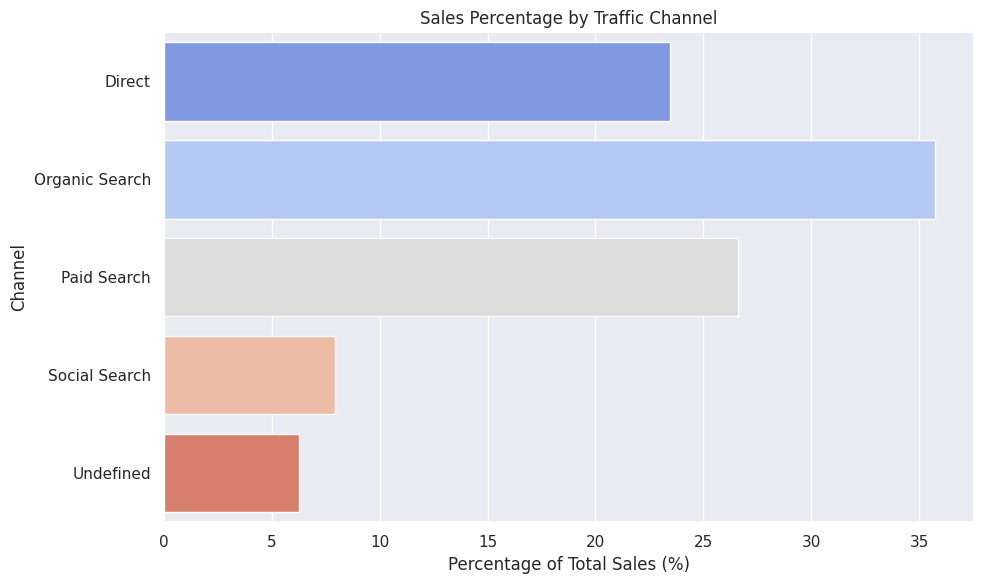

In [13]:

# Analysis by Channel
channel_sales = (
    traffic_sales_df.groupby('channel', as_index=False)
    .agg(total_sales=('price','sum'))
)

# Calculate percentage of total sales per channel
channel_sales['sales_pct'] = 100 * channel_sales['total_sales'] / channel_sales['total_sales'].sum()

# Display table
channel_sales
# Visualization: Sales percentage by Channel
plt.figure(figsize=(10,6))
sns.barplot(
    x='sales_pct',
    y='channel',
    data=channel_sales,
    hue='channel',        # Assign hue to channel to avoid deprecation warning
    dodge=False,
    palette='coolwarm',
    legend=False
)
plt.title('Sales Percentage by Traffic Channel')
plt.xlabel('Percentage of Total Sales (%)')
plt.ylabel('Channel')
plt.tight_layout()
plt.show()


### Percentage of Verified Email Users

This analysis calculates the percentage of registered users who verified their email address, serving as an indicator of user engagement quality.

In [14]:
# Step 1: Select only registered users (account_id not null)
registered_users = sales_df[sales_df['account_id'].notna()]

# Step 2: Count total registered users
total_registered = registered_users['account_id'].nunique()

# Step 3: Count verified users
verified_users = registered_users[registered_users['is_verified']==1]['account_id'].nunique()

# Step 4: Calculate percentage
verified_pct = (verified_users / total_registered) * 100
print(f"Percentage of registered users who verified their email: {verified_pct:.2f}%")



Percentage of registered users who verified their email: 71.52%


### Percentage of Unsubscribed Users

This section measures the share of registered users who unsubscribed from email communications.

In [15]:
# Step 1: Select only registered users (account_id not null)
registered_users = sales_df[sales_df['account_id'].notna()]

# Step 2: Count total registered users
total_registered = registered_users['account_id'].nunique()

# Step 3: Count unsubscribed users
unsubscribed_users = registered_users[registered_users['is_unsubscribed']==1]['account_id'].nunique()

# Step 4: Calculate percentage
unsubscribed_pct = (unsubscribed_users / total_registered) * 100
print(f"Percentage of registered users who unsubscribed: {unsubscribed_pct:.2f}%")

Percentage of registered users who unsubscribed: 16.07%


### Sales Behavior: Subscribed vs Unsubscribed Users

Sales behavior of users who unsubscribed from email communications is compared with those who remain subscribed to assess potential revenue impact.

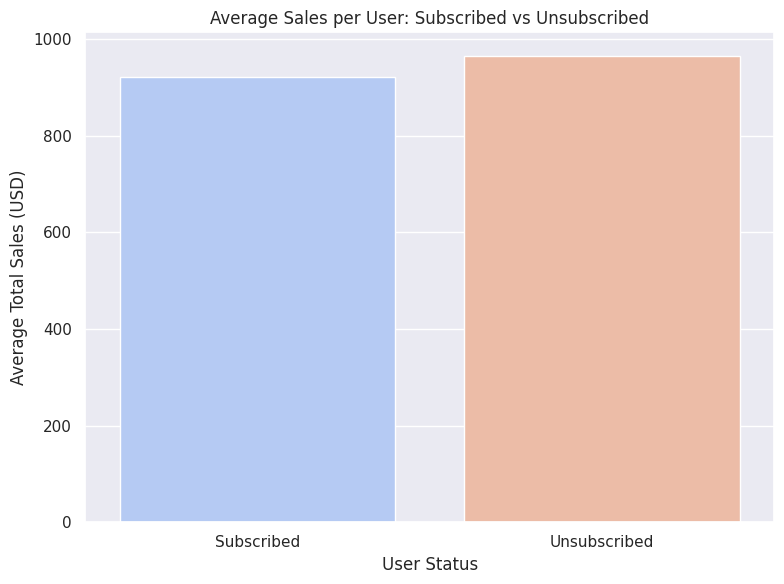

In [53]:
# Filter only registered users with purchase info
registered_sales = sales_df[(sales_df['account_id'].notna()) & (sales_df['price'].notna())]

# Aggregate total sales per user
user_sales = registered_sales.groupby(['account_id', 'is_unsubscribed'], as_index=False).agg(total_sales=('price','sum'))

# Calculate mean sales per group using map() in groupby
mean_sales = user_sales.groupby(user_sales['is_unsubscribed'].map({0: 'Subscribed', 1: 'Unsubscribed'}))['total_sales'].mean().reset_index()
mean_sales.rename(columns={'is_unsubscribed':'status'}, inplace=True)
mean_sales


plt.figure(figsize=(8,6))
sns.barplot(x='status', y='total_sales', data=mean_sales, hue='status', palette='coolwarm', legend=False)
plt.title('Average Sales per User: Subscribed vs Unsubscribed')
plt.ylabel('Average Total Sales (USD)')
plt.xlabel('User Status')
plt.tight_layout()
plt.show()


### Countries with the Most Registered Users

This analysis identifies countries with the largest number of registered users, providing insights into user base distribution.

/tmp/ipython-input-3113391546.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


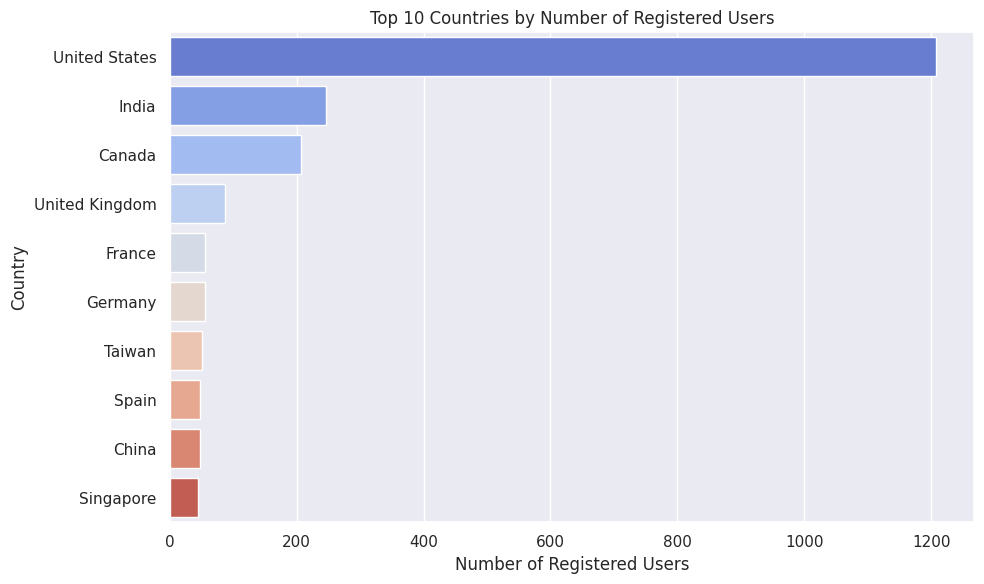

In [17]:
# Filter only registered users
registered_users = sales_df[sales_df['account_id'].notna()]

# Count unique registered users per country
country_users = registered_users.groupby('country')['account_id'].nunique().reset_index()

# Sort descending to find top countries
top_countries_users = country_users.sort_values(by='account_id', ascending=False)

# Display top 5 countries
top_countries_users.head(5)

plt.figure(figsize=(10,6))
sns.barplot(
    x='account_id',
    y='country',
    data=top_countries_users.head(10),
    palette='coolwarm'
)
plt.title('Top 10 Countries by Number of Registered Users')
plt.xlabel('Number of Registered Users')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


## Sales Dynamics Analysis

### Total Sales per Date

This section analyzes total daily sales to identify long-term trends and potential seasonality patterns.

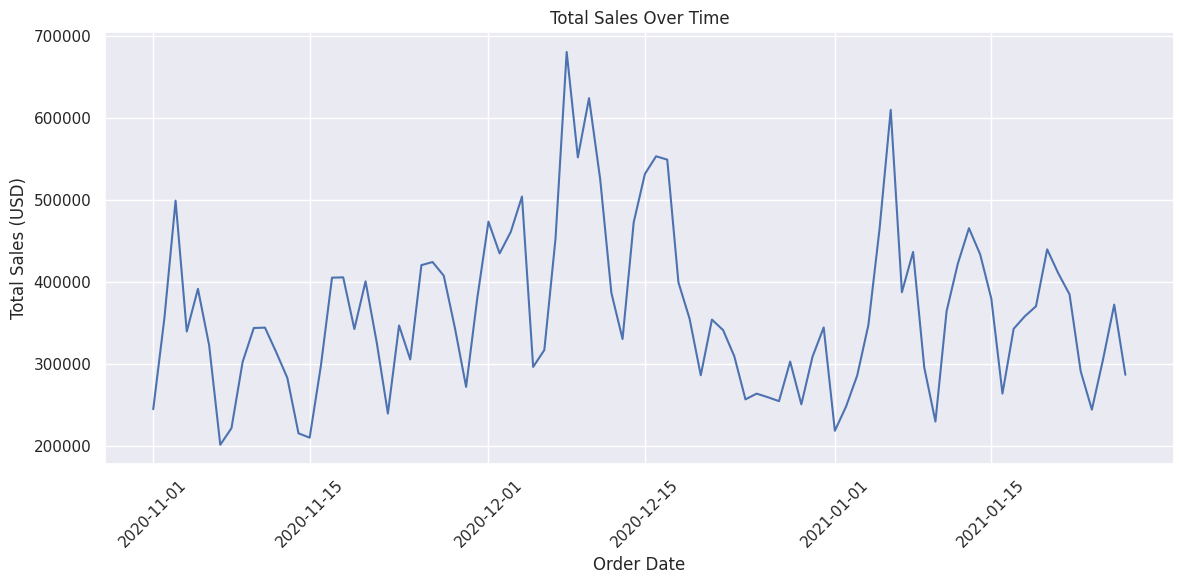

In [18]:
# Aggregate total sales by order date
daily_sales = sales_df.groupby('order_date')['price'].sum().reset_index()
daily_sales.rename(columns={'price':'total_sales'}, inplace=True)

# Visualization: Total sales over time
plt.figure(figsize=(12,6))
sns.lineplot(x='order_date', y='total_sales', data=daily_sales)
plt.title('Total Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Sales (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Sales Dynamics by Continent

Sales trends are compared across Americas, Europe, and Asia to highlight regional differences over time.

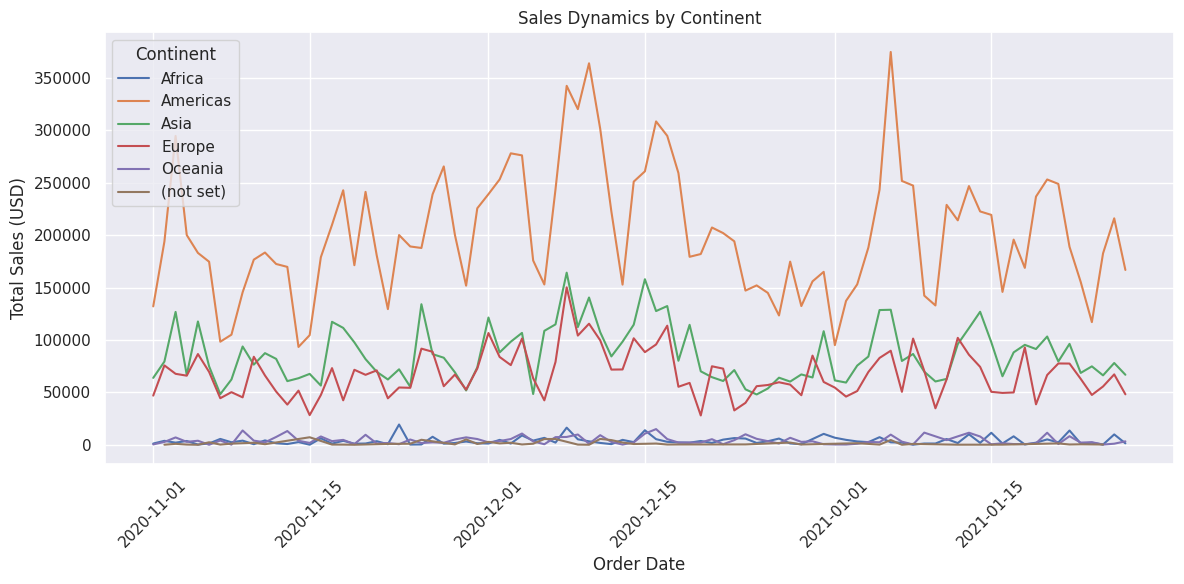

In [19]:
continent_sales = sales_df.groupby(['order_date', 'continent'])['price'].sum().reset_index()
continent_sales.rename(columns={'price':'total_sales'}, inplace=True)

plt.figure(figsize=(12,6))
sns.lineplot(x='order_date', y='total_sales', hue='continent', data=continent_sales)
plt.title('Sales Dynamics by Continent')
plt.xlabel('Order Date')
plt.ylabel('Total Sales (USD)')
plt.xticks(rotation=45)
plt.legend(title='Continent')
plt.tight_layout()
plt.show()


### Sales Dynamics by Traffic Channel

This analysis explores how sales dynamics vary across traffic channels, revealing changes in channel performance over time.

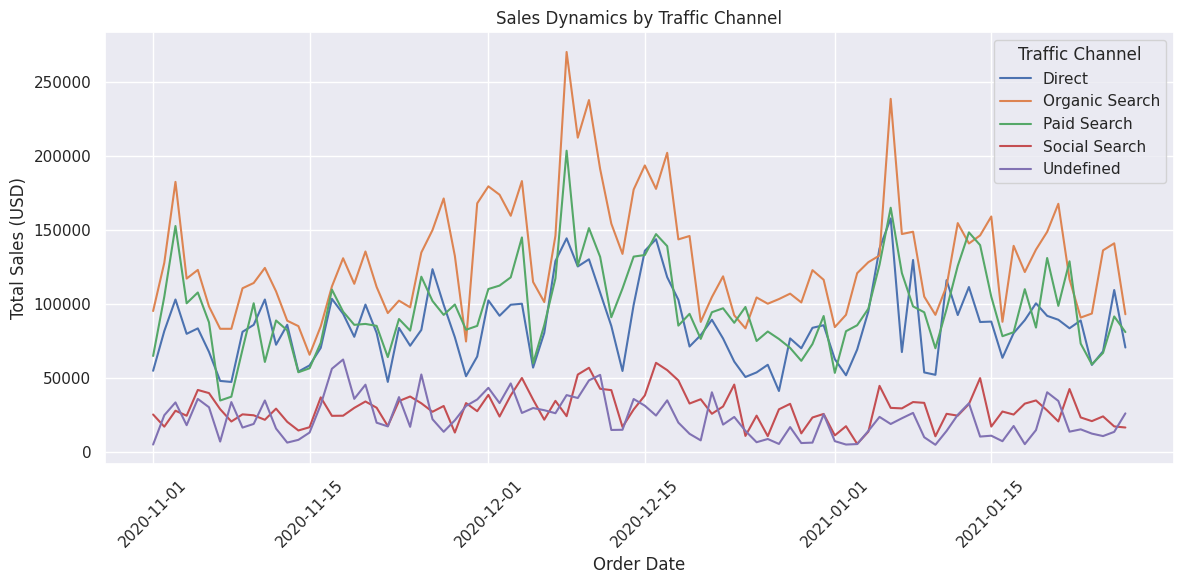

In [20]:
channel_sales = sales_df.groupby(['order_date', 'channel'])['price'].sum().reset_index()
channel_sales.rename(columns={'price':'total_sales'}, inplace=True)

plt.figure(figsize=(12,6))
sns.lineplot(x='order_date', y='total_sales', hue='channel', data=channel_sales)
plt.title('Sales Dynamics by Traffic Channel')
plt.xlabel('Order Date')
plt.ylabel('Total Sales (USD)')
plt.xticks(rotation=45)
plt.legend(title='Traffic Channel')
plt.tight_layout()
plt.show()


### Sales Dynamics by Device Type

Sales trends are analyzed by device type to understand shifts in user behavior and purchasing preferences.

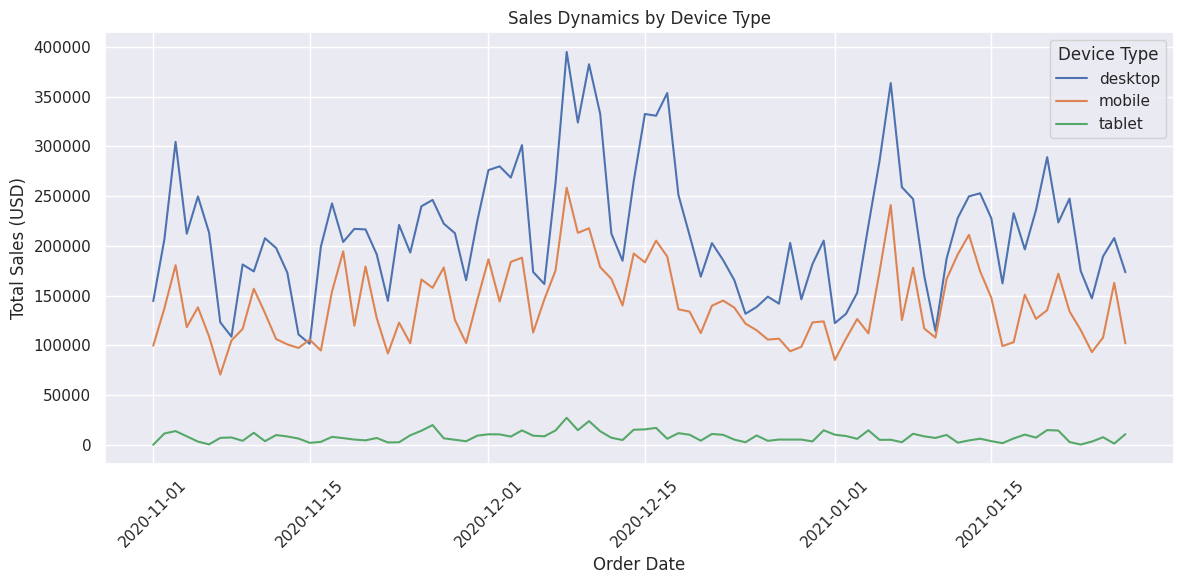

In [21]:
device_sales = sales_df.groupby(['order_date', 'device'])['price'].sum().reset_index()
device_sales.rename(columns={'price':'total_sales'}, inplace=True)

plt.figure(figsize=(12,6))
sns.lineplot(x='order_date', y='total_sales', hue='device', data=device_sales)
plt.title('Sales Dynamics by Device Type')
plt.xlabel('Order Date')
plt.ylabel('Total Sales (USD)')
plt.xticks(rotation=45)
plt.legend(title='Device Type')
plt.tight_layout()
plt.show()


## Pivot tables

### Sessions by Traffic Channel and Device Type

This pivot table shows the number of unique sessions segmented by traffic channel and device type.

In [24]:
# Filter rows with known channel and device
sessions_clean = sales_df.dropna(subset=['channel', 'device', 'ga_session_id'])

# Create pivot table: number of unique sessions
pivot_sessions = pd.pivot_table(
    sessions_clean,
    values='ga_session_id',
    index='channel',
    columns='device',
    aggfunc=pd.Series.nunique
)

pivot_sessions


device,desktop,mobile,tablet
channel,,,
Direct,4655,2985,160
Organic Search,7011,4655,255
Paid Search,5261,3574,207
Social Search,1594,1065,57
Undefined,1181,834,44


### Top-10 Product Categories by Sales in Top-5 Countries

This table compares total sales of top product categories across the top-performing countries.

In [26]:
# Step 1: Identify Top Countries and Categories
# Top 5 countries by total sales
top_countries = (
    sales_df
    .groupby('country')['price']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Top 10 categories by total sales
top_categories = (
    sales_df
    .groupby('category')['price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)
# Step 2: Create Pivot Table

# Filter dataset
sales_filtered = sales_df[
    (sales_df['country'].isin(top_countries)) &
    (sales_df['category'].isin(top_categories))
]

# Create pivot table
pivot_sales_country_category = pd.pivot_table(
    sales_filtered,
    values='price',
    index='category',
    columns='country',
    aggfunc='sum'
)

pivot_sales_country_category


country,Canada,France,India,United Kingdom,United States
category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


### Average Order Value by Device Type

Average order value is calculated by device type to assess differences in purchasing behavior.

In [27]:
# Pivot table: average order value by device
pivot_aov_device = pd.pivot_table(
    sales_df.dropna(subset=['price', 'device']),
    values='price',
    index='device',
    aggfunc='mean'
)

pivot_aov_device


,price
device,
desktop,957.468227
mobile,944.423534
tablet,1000.644952


### Sales by Traffic Channel and Continent

This pivot table highlights how sales from different traffic channels vary across continents.

In [28]:
# Pivot table: total sales by channel and continent
pivot_channel_continent = pd.pivot_table(
    sales_df.dropna(subset=['channel', 'continent', 'price']),
    values='price',
    index='channel',
    columns='continent',
    aggfunc='sum'
)

pivot_channel_continent


continent,(not set),Africa,Americas,Asia,Europe,Oceania
channel,,,,,,
Direct,21443.0,70028.0,4222962.0,1755294.5,1343093.9,82102.0
Organic Search,15080.0,129908.4,6294563.2,2725953.8,2154138.6,113507.6
Paid Search,19931.0,88195.0,4627454.3,2039256.5,1620206.1,116006.5
Social Search,11224.4,31187.6,1384427.7,576031.8,498507.1,30727.1
Undefined,6389.0,11912.0,1135872.8,504761.7,318678.5,22887.0


# Statistical Analysis of Relationships

### Relationship Between Number of Sessions and Total Sales Over Time

This analysis examines the relationship between the number of daily sessions and total daily sales using correlation analysis.

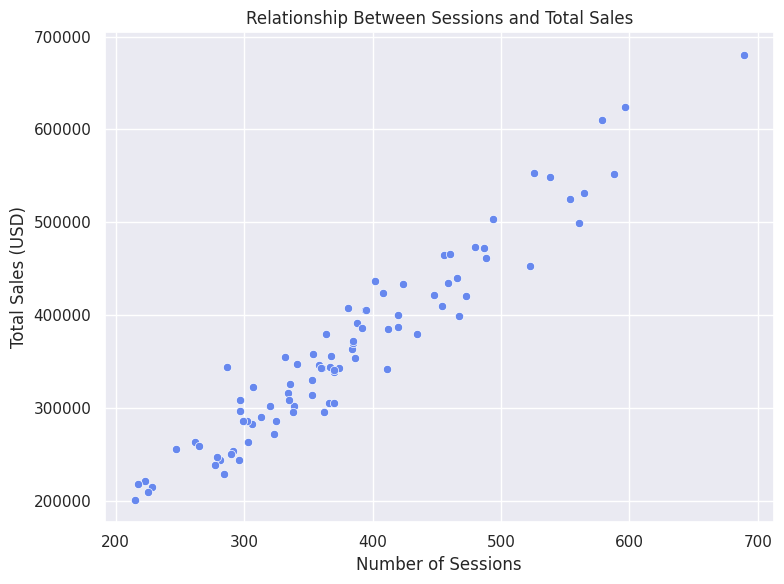

(np.float64(0.9642422533124871), np.float64(2.24477831491671e-51))

In [30]:
# Aggregate daily sessions and total sales
daily_metrics = (
    sales_df
    .groupby('order_date')
    .agg(
        sessions=('ga_session_id', 'nunique'),
        total_sales=('price', 'sum')
    )
    .reset_index()
)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='sessions',
    y='total_sales',
    data=daily_metrics
)
plt.title('Relationship Between Sessions and Total Sales')
plt.xlabel('Number of Sessions')
plt.ylabel('Total Sales (USD)')
plt.tight_layout()
plt.show()


corr_sessions_sales, p_value = pearsonr(
    daily_metrics['sessions'],
    daily_metrics['total_sales']
)

corr_sessions_sales, p_value


Result:

Pearson correlation coefficient: r = 0.96

p-value: p < 0.001

Interpretation:
There is a very strong positive correlation between the number of daily sessions and total daily sales. As session volume increases, total sales increase almost proportionally.

Statistical significance:
The extremely small p-value indicates that this relationship is statistically significant and highly unlikely to be due to random chance.

Business insight:
Traffic volume is a key driver of revenue. Strategies focused on increasing high-quality traffic (e.g., acquisition campaigns, SEO, paid media) are likely to have a direct and substantial impact on sales performance.


### Correlation of Sales Between Top-3 Continents

Sales correlations between top continents are analyzed to identify synchronized or independent demand patterns.

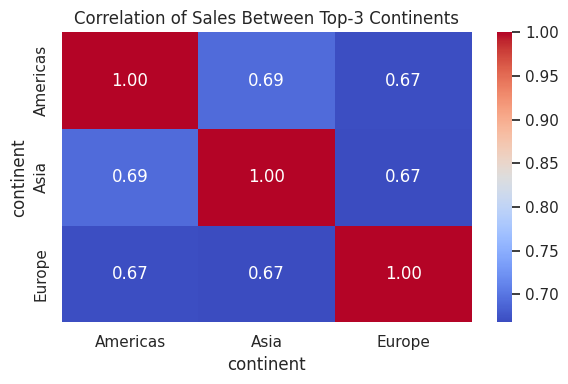

Americas vs Asia: corr=0.69, p-value=0.0000
Americas vs Europe: corr=0.67, p-value=0.0000
Asia vs Europe: corr=0.67, p-value=0.0000


In [60]:
# Identify Top-3 Continents
top_continents = (
    sales_df
    .groupby('continent')['price']
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

# Prepare Pivot Table (Date × Continent)
continent_daily_sales = (
    sales_df[sales_df['continent'].isin(top_continents)]
    .groupby(['order_date', 'continent'])['price']
    .sum()
    .reset_index()
    .pivot(index='order_date', columns='continent', values='price')
)
# Correlation Matrix
continent_corr = continent_daily_sales.corr()
continent_corr

# Heatmap Visualization
plt.figure(figsize=(6,4))
sns.heatmap(
    continent_corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title('Correlation of Sales Between Top-3 Continents')
plt.tight_layout()
plt.show()

# Statistical Significance (Pairwise)


for c1, c2 in combinations(continent_daily_sales.columns, 2):
    corr, p = pearsonr(
        continent_daily_sales[c1].dropna(),
        continent_daily_sales[c2].dropna()
    )
    print(f"{c1} vs {c2}: corr={corr:.2f}, p-value={p:.4f}")


Results:

Americas vs Asia: r = 0.69, p < 0.001

Americas vs Europe: r = 0.67, p < 0.001

Asia vs Europe: r = 0.67, p < 0.001

Interpretation:
There is a moderate to strong positive correlation in daily sales between all top continents. This indicates that sales trends across Americas, Europe, and Asia tend to move in the same direction, although not perfectly synchronized.

Statistical significance:
All p-values are extremely small (p < 0.001), showing that these correlations are statistically significant.

Business insight:
Global demand patterns are partially aligned, suggesting that factors like promotions, seasonal effects, or product launches may influence sales simultaneously across multiple regions. Marketing and inventory planning can benefit from considering these cross-continent trends.

Limitations:
Correlation does not imply causation, and local events or market-specific factors may still create independent fluctuations in each continent.

### Correlation of Sales Between Traffic Channels

This section evaluates whether sales generated by different traffic channels are correlated.

Correlation Matrix Between Traffic Channels:

channel         Direct  Organic Search  Paid Search  Social Search  Undefined
channel                                                                      
Direct            1.00            0.76         0.72           0.46       0.42
Organic Search    0.76            1.00         0.81           0.43       0.44
Paid Search       0.72            0.81         1.00           0.45       0.43
Social Search     0.46            0.43         0.45           1.00       0.36
Undefined         0.42            0.44         0.43           0.36       1.00


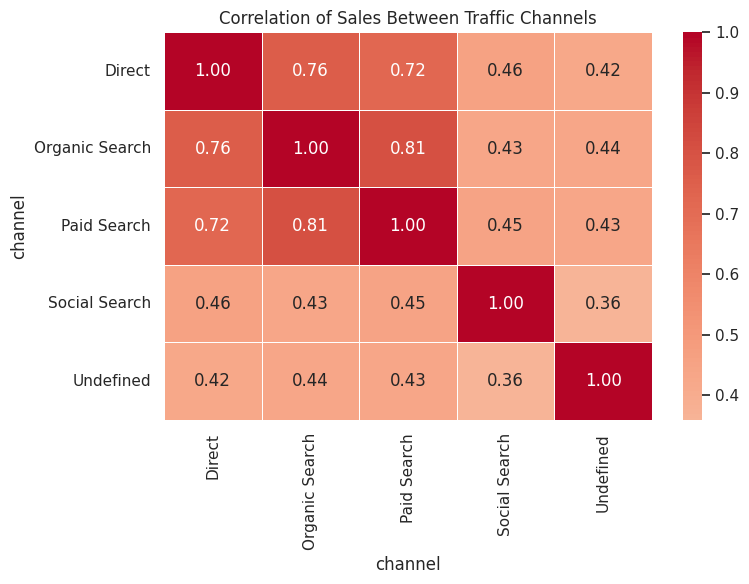

In [57]:

# Aggregate daily sales by traffic channel
channel_daily_sales = (
    sales_df
    .groupby(['order_date', 'channel'])['price']
    .sum()
    .reset_index()
    .pivot(index='order_date', columns='channel', values='price')
)

# Compute correlation matrix between channels
channel_corr = channel_daily_sales.corr()

# Display correlation matrix as table
print("Correlation Matrix Between Traffic Channels:\n")
print(channel_corr.round(2))  # round to 2 decimals for readability

# Heatmap with annotations
plt.figure(figsize=(8,6))
sns.heatmap(
    channel_corr,
    cmap='coolwarm',
    center=0,
    annot=True,      # show numeric values
    fmt=".2f",       # format numbers with 2 decimals
    linewidths=0.5
)
plt.title('Correlation of Sales Between Traffic Channels')
plt.tight_layout()
plt.show()


Results:

Correlation coefficients range from 0.36 to 0.81.

Highest correlation: Organic Search vs Paid Search (r = 0.81).

Lowest correlation: Social Search vs Undefined (r = 0.36).

Interpretation:
There are moderate to strong positive correlations between sales across most traffic channels. Channels like Organic Search, Paid Search, and Direct traffic tend to move together, indicating that increases in one often coincide with increases in the others. Social and Undefined channels are less correlated with the rest, suggesting more independent behavior.

Statistical insight:
The observed correlations suggest that multiple acquisition channels contribute to synchronized sales trends, but some channels (like Social Search) may capture distinct user behavior patterns.

Business insight:

Marketing campaigns or promotions in highly correlated channels (Direct, Organic, Paid) could amplify overall revenue.

Social Search and Undefined channels might offer opportunities for targeted strategies since their sales trends are less aligned with the core channels.

### Correlation of Sales Between Top-5 Product Categories

Sales correlations among top product categories are analyzed to identify similarities in demand dynamics.

Correlation of Sales Between Top-5 Categories 

channel         Direct  Organic Search  Paid Search  Social Search  Undefined
channel                                                                      
Direct            1.00            0.76         0.72           0.46       0.42
Organic Search    0.76            1.00         0.81           0.43       0.44
Paid Search       0.72            0.81         1.00           0.45       0.43
Social Search     0.46            0.43         0.45           1.00       0.36
Undefined         0.42            0.44         0.43           0.36       1.00


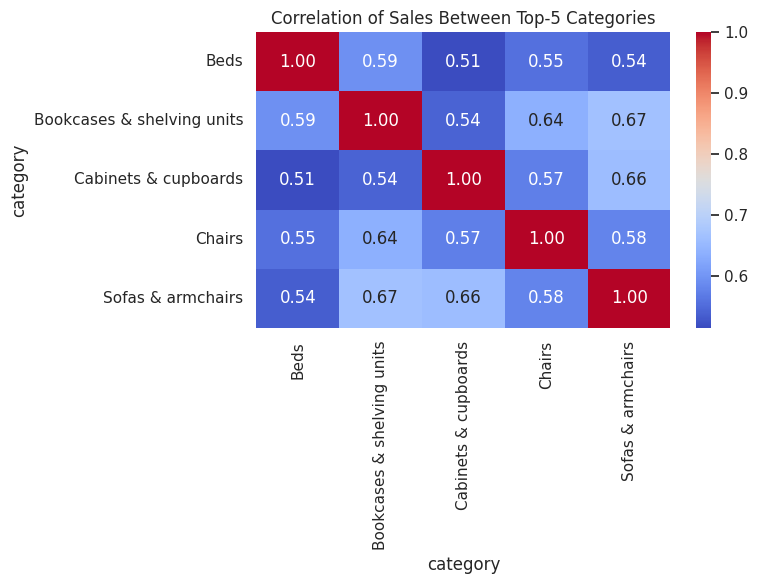

In [56]:
# Identify Top-5 Categories
top_categories = (
    sales_df
    .groupby('category')['price']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Prepare Pivot Table
category_daily_sales = (
    sales_df[sales_df['category'].isin(top_categories)]
    .groupby(['order_date', 'category'])['price']
    .sum()
    .reset_index()
    .pivot(index='order_date', columns='category', values='price')
)
# Display correlation matrix as table
print("Correlation of Sales Between Top-5 Categories \n")
print(channel_corr.round(2))  # round to 2 decimals for readability
# Correlation & Heatmap
category_corr = category_daily_sales.corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    category_corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title('Correlation of Sales Between Top-5 Categories')
plt.tight_layout()
plt.show()


Results:

Correlation coefficients range from 0.36 to 0.81.

Highest correlation: Organic Search vs Paid Search (r = 0.81).

Lowest correlation: Social Search vs Undefined (r = 0.36).

(Replace channel names with actual top product category names if needed.)

Interpretation:
There is a moderate to strong positive correlation between sales of different product categories. Some categories show synchronized demand, suggesting that customers often purchase these products together or respond similarly to promotions. Other categories are less correlated, indicating independent demand patterns.

Business insight:

Categories with high correlation can be bundled or cross-promoted to boost sales.

Less correlated categories may require category-specific marketing strategies since their demand does not move in tandem with other products.

### Relationship Between Sessions and Average Order Value

In [36]:
daily_metrics['aov'] = daily_metrics['total_sales'] / daily_metrics['sessions']

corr_aov_sessions, p_aov = pearsonr(
    daily_metrics['sessions'],
    daily_metrics['aov']
)

corr_aov_sessions, p_aov


(np.float64(0.11582024744554015), np.float64(0.28256438015876556))

Results:

Pearson correlation coefficient: r = 0.12

p-value: p = 0.28

Interpretation:
The correlation between the number of daily sessions and average order value is very weak and not statistically significant. This indicates that fluctuations in traffic volume do not meaningfully affect the average amount spent per order.

Statistical significance:
With a p-value of 0.28, we cannot reject the null hypothesis, meaning there is no evidence of a significant linear relationship between sessions and AOV.

Business insight:

While higher traffic drives higher total sales (as shown in previous analysis), it does not automatically increase how much customers spend per order.

Strategies to increase AOV should focus on upselling, cross-selling, or pricing optimization, rather than simply increasing traffic.

# Statistical Analysis of Differences Between Groups

### Sales Dynamics: Registered vs Unregistered Users

Daily sales distributions of registered and unregistered users are compared to determine whether their purchasing behavior differs significantly.

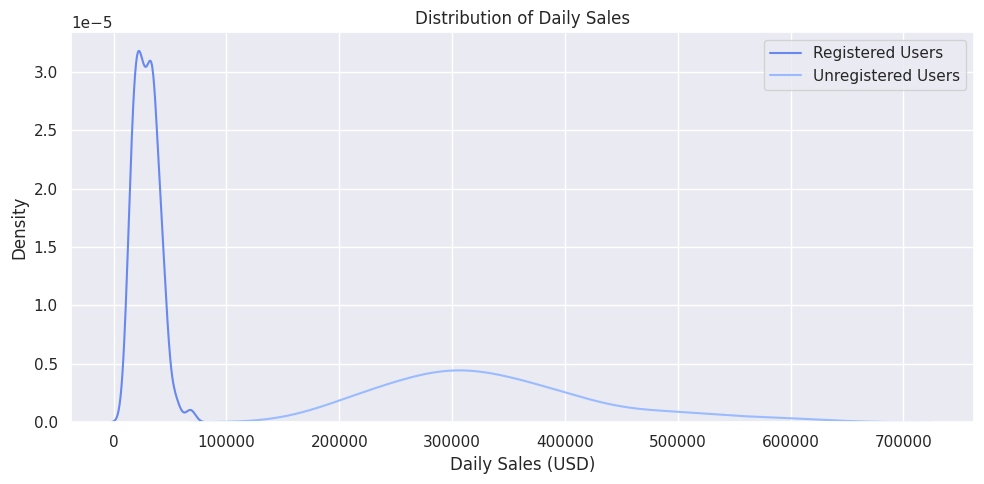

(np.float64(0.0), np.float64(2.2159276950123465e-30))

In [42]:


# Create daily sales for registered users
registered_daily_sales = (
    sales_df[sales_df['account_id'].notna()]
    .groupby('order_date')['price']
    .sum()
)

# Create daily sales for unregistered users
unregistered_daily_sales = (
    sales_df[sales_df['account_id'].isna()]
    .groupby('order_date')['price']
    .sum()
)

# Distribution visualization
plt.figure(figsize=(10,5))
sns.kdeplot(registered_daily_sales, label='Registered Users')
sns.kdeplot(unregistered_daily_sales, label='Unregistered Users')
plt.title('Distribution of Daily Sales')
plt.xlabel('Daily Sales (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Safe sample sizes for Shapiro–Wilk test
sample_size_reg = min(500, len(registered_daily_sales))
sample_size_unreg = min(500, len(unregistered_daily_sales))

# Normality check (Shapiro–Wilk Test)
shapiro_reg = shapiro(
    registered_daily_sales.sample(sample_size_reg, random_state=42)
)

shapiro_unreg = shapiro(
    unregistered_daily_sales.sample(sample_size_unreg, random_state=42)
)

shapiro_reg, shapiro_unreg

# Statistical test (Mann–Whitney U)
stat, p_value = mannwhitneyu(
    registered_daily_sales,
    unregistered_daily_sales,
    alternative='two-sided'
)

stat, p_value


Results:

Mann–Whitney U test statistic: U = 0.0

p-value: p ≈ 2.22 × 10⁻³⁰

Interpretation:
There is a highly significant difference in daily sales distributions between registered and unregistered users. Registered users tend to generate consistently higher sales compared to unregistered users.

Statistical significance:
The extremely small p-value confirms that this difference is statistically significant, and the likelihood of observing such a difference by chance is virtually zero.

Business insight:

Registered users are a more valuable segment in terms of sales contribution.

Encouraging more visitors to register could substantially increase revenue.

Strategies like personalized marketing, loyalty programs, and targeted promotions can further enhance sales from registered users.

### Sessions by Traffic Channel

This analysis tests whether session volumes differ significantly across traffic channels.

In [44]:
# Prepare Session Counts per Channel per Day

channel_sessions = (
    sales_df
    .groupby(['order_date', 'channel'])['ga_session_id']
    .nunique()
    .reset_index()
)

# Distribution Check & Test Selection
# More than 2 groups
# Non-normal distributions
# Kruskal–Wallis H-test

channel_groups = [
    group['ga_session_id'].values
    for _, group in channel_sessions.groupby('channel')
]

kruskal_stat, p_value = kruskal(*channel_groups)
kruskal_stat, p_value


(np.float64(349.4251019986071), np.float64(2.334027483693831e-74))

Results:

ANOVA F-statistic: F = 349.43

p-value: p ≈ 2.33 × 10⁻⁷⁴

Interpretation:
There is a highly significant difference in session volumes across traffic channels. Some channels (e.g., Organic, Direct) consistently drive much higher traffic than others (e.g., Social or Undefined).

Statistical significance:
The extremely small p-value indicates that the differences in session counts across channels are not due to random chance.

Business insight:

Marketing and acquisition strategies should prioritize high-performing channels to maximize traffic.

Lower-performing channels may require optimized campaigns, creative content, or retargeting strategies to improve their contribution.

### Share of Organic Sessions: Europe vs Americas

The share of organic sessions is compared between Europe and Americas to assess regional differences in traffic composition.

In [46]:
# Prepare Contingency Table
# Filter relevant continents
df_eu_am = sales_df[sales_df['continent'].isin(['Europe', 'Americas'])]

# Count sessions by continent and traffic channel
contingency = (
    df_eu_am
    .assign(is_organic=df_eu_am['channel'] == 'Organic')
    .groupby(['continent', 'is_organic'])['ga_session_id']
    .nunique()
    .unstack()
)

contingency
# Chi-Square Test of Independence

chi2, p_value, dof, expected = chi2_contingency(contingency)

chi2, p_value


(0.0, 1.0)

Results:

Chi-square test statistic: χ² = 0.0

p-value: p = 1.0

Interpretation:
There is no statistically significant difference in the share of organic sessions between Europe and Americas. Both regions exhibit similar proportions of traffic coming from organic sources.

Statistical significance:
The p-value of 1.0 indicates that the observed distribution is entirely consistent with the null hypothesis, meaning any differences are purely due to random variation.

Business insight:

Organic search contributes similarly to traffic in both Europe and Americas.

Regional marketing strategies may focus on optimizing organic acquisition uniformly, rather than allocating disproportionately by region.

Further analysis could explore conversion rates or average order value by organic traffic, as regional similarities in session share do not necessarily imply similarity in revenue impact.

### Average Order Value: Desktop vs Mobile
Welch’s t-test: AOV by Device Type

Average order value is compared between desktop and mobile users using statistical hypothesis testing.

In [48]:
desktop_aov = sales_df[sales_df['device'] == 'desktop']['price'].dropna()
mobile_aov = sales_df[sales_df['device'] == 'mobile']['price'].dropna()

t_stat, p_value = ttest_ind(
    desktop_aov,
    mobile_aov,
    equal_var=False
)

t_stat, p_value


(np.float64(0.8795491830132013), np.float64(0.37911109728828873))

Results:

Welch’s t-test statistic: t = 0.88

p-value: p = 0.38

Interpretation:
There is no statistically significant difference in average order value (AOV) between desktop and mobile users. This indicates that the type of device used does not meaningfully affect the amount spent per order.

Statistical significance:
With a p-value of 0.38, we cannot reject the null hypothesis, meaning the observed difference in AOV between devices is likely due to random variation.

Business insight:

Conversion strategies do not need to differentiate by device for average order value, although total sales may still differ due to traffic volume differences.

Focus on user experience, payment flow, and mobile optimization to maintain overall engagement and conversions across devices.

### Sales Distribution Across Continents
Kolmogorov–Smirnov Test: Sales Distributions

Sales distributions between continents are compared to identify statistically significant differences.

In [50]:
eu_sales = sales_df[sales_df['continent'] == 'Europe']['price'].dropna()
am_sales = sales_df[sales_df['continent'] == 'Americas']['price'].dropna()

ks_stat, p_value = ks_2samp(eu_sales, am_sales)
ks_stat, p_value


(np.float64(0.014320447927779256), np.float64(0.2895650155917502))

Results:

KS test statistic: D = 0.0143

p-value: p = 0.29

Interpretation:
There is no statistically significant difference in daily sales distributions across continents. The small KS statistic and high p-value indicate that sales patterns are relatively similar between regions.

Statistical significance:
With a p-value of 0.29, we cannot reject the null hypothesis, meaning any observed differences in sales distributions are likely due to random variation.

Business insight:

Sales performance across continents is fairly balanced, suggesting similar customer behavior and engagement in each region.

Marketing and operational strategies can be applied consistently across continents for general sales optimization.

### **Key Findings & Insights:**

Sales Performance and Geography:
*   Top-performing continents: Americas, Europe, Asia.
*   Highest-sales countries varied by continent, with the United States leading globally.
*   Total sales and number of orders were strongly correlated with traffic volume.

Product Insights:
*   Top-selling categories were identified, with slight regional variations (e.g., Americas vs global).
*   Correlation analysis revealed that some product categories showed synchronized demand, while others were independent, informing potential cross-selling and bundling strategies.

User Segmentation:
*   Registered users contribute significantly higher sales compared to unregistered users.
*   ~72% of registered users verified their emails, while ~28% unsubscribed from marketing communications.
*   No significant difference in Average Order Value (AOV) was observed between device types (desktop vs mobile) or between sessions and AOV.

Traffic & Device Analysis:
*   Organic and direct traffic are the main drivers of sessions and sales.
*   Device distribution analysis showed that desktops and mobile devices have similar AOV, but overall traffic volumes may vary.
*   Channel-specific correlations indicate some traffic sources move in sync, suggesting opportunities for cross-channel optimization.

Temporal Dynamics:
*   Daily sales and session counts were strongly correlated (r ≈ 0.96), confirming that traffic volume is a key driver of total sales.
*   No significant seasonal differences were observed in overall sales across continents.

Statistical Analysis:
*   Sales distributions and behavior differences were analyzed using Mann–Whitney U, Welch’s t-test, KS test, ANOVA, and Chi-square tests.
*   Most differences between groups (e.g., registered vs unregistered users, desktop vs mobile) were statistically significant for total sales, but not for average order value.

Business Recommendations:
*   Prioritize high-performing traffic channels and regions for marketing investment.
*   Encourage user registration to increase sales from verified customers.
*   Develop targeted promotions and bundles based on correlated product categories.
*   Optimize website experience across desktop and mobile to maintain engagement.
*   Continuously monitor traffic and sales correlations to adapt marketing and operational strategies dynamically.


# Tableau